# Output layer weights 

In [4]:
import tensorflow as tf 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

import keras
from keras.datasets import cifar10
from keras.models import Sequential 
from keras.models import model_from_json
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

%matplotlib inline

## Data acquisition & hyperparameter setting

In [5]:
batch_size = 32
num_classes = 10
epochs = 1
data_augmentation = True

In [6]:
# The data, shuffled and split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [7]:
# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

## Build model 

In [8]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        18496     
__________

## Compile Model 

In [9]:
# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

In [10]:
# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
x_train.shape

(50000, 32, 32, 3)

In [11]:
 print('Not using data augmentation.')
model.fit(x_train[:20000], y_train[:20000],
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test),
          shuffle=True)

Not using data augmentation.
Train on 20000 samples, validate on 10000 samples
Epoch 1/1
20000/20000 [==============================] - 289s - loss: 2.0332 - acc: 0.2501 - val_loss: 1.8250 - val_acc: 0.3569

## Retrieve weights from Layers 

In [12]:
print(len(model.layers[0].get_weights()))
print(model.layers[0].get_weights()[0].shape)
print(model.layers[0].get_weights()[1].shape)
conv1_weights = model.layers[0].get_weights()[0]
conv1_biases = model.layers[0].get_weights()[1]
model.layers[0].get_weights()[0]

2
(3, 3, 3, 32)
(32,)


array([[[[ 0.0556595 ,  0.09106687,  0.0952794 , -0.07818365,  0.05960592,
           0.13091703,  0.14947316,  0.13326134, -0.10681936, -0.10567041,
           0.12215956,  0.0802748 ,  0.04450392,  0.00048477,  0.11889506,
           0.03521046, -0.03748699, -0.08963996,  0.02083039,  0.12819295,
           0.04273948,  0.13970801, -0.01928986, -0.03323125,  0.05116474,
           0.00274411,  0.05294781, -0.06317707, -0.00190593,  0.08520786,
           0.03848021, -0.01069758],
         [ 0.02940613, -0.02856179, -0.03034916,  0.06506472,  0.06601148,
           0.0202391 , -0.11831344,  0.01285229, -0.07415377, -0.11608568,
           0.04489761,  0.12055461,  0.13345225, -0.10011332, -0.12304367,
          -0.10735974, -0.11884381,  0.08546261,  0.05049191,  0.0410815 ,
          -0.03770501, -0.04237143,  0.06747782,  0.03644151,  0.10892386,
           0.11004978,  0.01887542, -0.12749888, -0.01290551, -0.03063028,
          -0.05524983, -0.12101046],
         [-0.07929356, -0.

## Visualize layers 

(3, 3, 3)


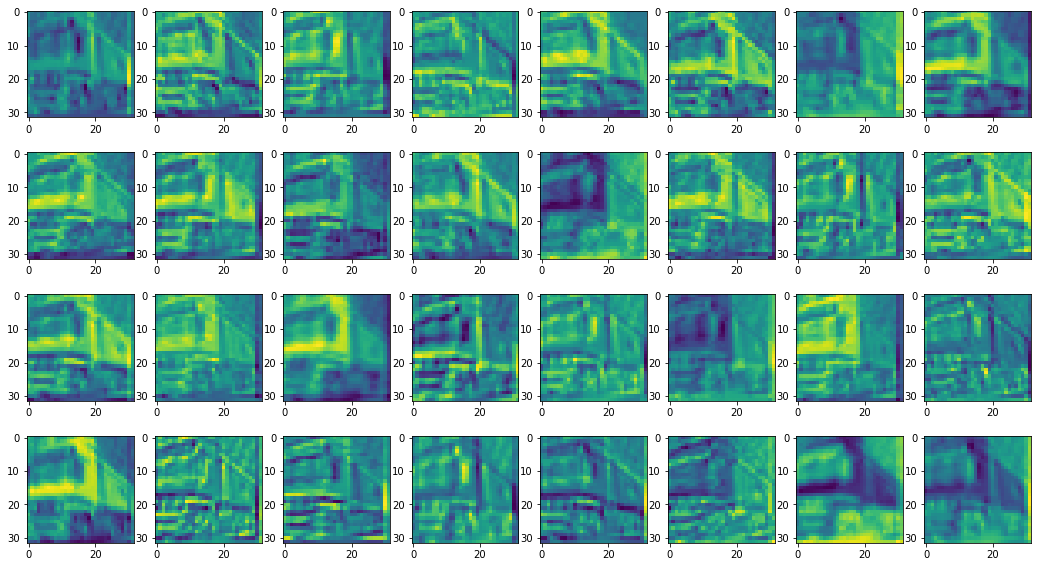

In [44]:
def get_filter(weights, biases, index):
    filter_weights = [weights[i][j][k][index] for i in range(weights.shape[0]) \
                     for j in range(weights.shape[1]) for k in range(weights.shape[2])]
    return np.asarray(filter_weights).reshape((3,3,3)), biases[index]

print(get_filter(conv1_weights, conv1_biases, 0)[0].shape)
    
def generate_padded_noise_image(shape):
    # shape = [32, 32, 3] here
#     noise = np.random.normal(size=shape)
    noise = x_train[1] #np.ones(shape)
    padded_image = np.zeros([shape[0]+4, shape[1]+4, shape[2]])
    padded_image[2:shape[0]+2, 2:shape[1]+2, :] = noise 
    return padded_image

def filter_mapping(image, filter_weights, filter_bias, x_index, y_index, padded=True, pad=2):
    if padded:
        x_start = pad + x_index
        y_start = pad + y_index
        x_end = x_start + filter_weights.shape[0]
        y_end = y_start + filter_weights.shape[1]
        temp = image[x_start: x_end, y_start: y_end, :]
        summation = np.sum(np.multiply(temp, filter_weights)) + filter_bias
        return summation 

def trim_padding(image):
    s = image.shape
    unpadded_image = image[2:s[0]-2, 2:s[1]-2, :].copy()
    return unpadded_image 
    
def generate_filter_visualization(size, weight, bias):
    blank = generate_padded_noise_image(size)
    image = [filter_mapping(blank, weight, bias, i, j) for i in range(size[0]) for j in range(size[1])]
    return np.asarray(image).reshape([size[0], size[1]])
    
def draw_visualizations(shape, weights, biases):
    plt.figure(figsize=(18,10))
    for i in range(weights.shape[3]):
        plt.subplot(4, 8, i+1)
        weight, bias = get_filter(weights, biases, i)
        filter_image = generate_filter_visualization(shape, weight, bias)
#         print(filter_image.shape)
        plt.imshow(filter_image)

    plt.show()    
    
def draw_filters(weights, biases):
#     plt.figure(figsize=(18,10))
    for i in range(weights.shape[3]):
        weight, bias = get_filter(weights, biases, i)
        plt.imshow(weight)
        
    plt.show()
# weight, bias = get_filter(conv1_weights, conv1_biases, 0)    
# image = generate_filter_visualization([32, 32, 3], weight, bias)
# plt.imshow(image)
draw_visualizations([32, 32, 3], conv1_weights, conv1_biases)
# draw_filters(conv1_weights, conv1_biases)

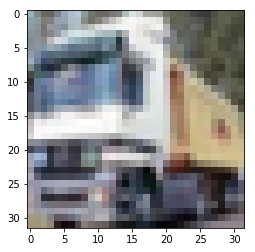

In [43]:
plt.imshow(x_train[1])

## Save the model & trained weights 

In [16]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


## Reload model & weights 

In [38]:
import h5py 
fpath = "params/model.h5"
f = h5py.File(fpath, 'r')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        18496     
__________

In [ ]:
print(len(model.layers[0].get_weights()))
print(model.layers[0].get_weights()[0].shape)
print(model.layers[0].get_weights()[1].shape)
conv1_weights = model.layers[0].get_weights()[0]
conv1_biases = model.layers[0].get_weights()[1]
model.layers[0].get_weights()[0]